# Кейс Air Passengers

В данном кейсе рассматриваются данные о числе пассажиров в Соединенных Штатах за период с 1949 по 1960 год. Они представлены в виде временного ряда (прим. значения переменной собранные в различные моменты времени), данные собирались ежемесячно. В этот временной период наблюдался экспоненциальный рост популярности авиатранспорта как способа путешествий. Перед менеджментом стоит вопрос об эффективности функционирования индустрии, а также предсказание количества пассажиров в следующие временные периоды. Это необходимо для того чтобы авиакомпании могли удовлетворить их потребности и не существовал избыточный спрос. Как можно рассчитать эти значения при условии сильного положительного тренда и сезонности?

Сначала необходимо загрузить пакеты, которые будут использоваться в кейсе.

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

Данные представляют собой число пассажиров в Соединеннных Штатах за каждый месяц с января 1949 года по декабрь 1960 года. В колонке Month указан месяц, в #Passengers - число пассажиров.

In [2]:
data = pd.read_csv("AirPassengers.csv")
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


Посмотрим, какие типы данных представлены в датасете.

In [3]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

Преобразуем данные в столбце Month в формат datetime.

In [4]:
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)
data

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


Фильтруем данные по показателю год, выбираем данные позднее 1955 года, например.

In [5]:
data[data['Month'].dt.year >= 1955]

,Month,#Passengers
72,1955-01-01,242
73,1955-02-01,233
74,1955-03-01,267
75,1955-04-01,269
76,1955-05-01,270
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


Можно фильтровать по месяц, выбираем  только месяц май за все годы.

In [6]:
data[data['Month'].dt.month == 5]

,Month,#Passengers
4,1949-05-01,121
16,1950-05-01,125
28,1951-05-01,172
40,1952-05-01,183
52,1953-05-01,229
64,1954-05-01,234
76,1955-05-01,270
88,1956-05-01,318
100,1957-05-01,355
112,1958-05-01,363


Ставим переменную Month как индексную для удобства дальнейшей работы.

In [7]:
data = data.set_index(['Month'])
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Отрисуем на графике временной ряд, по оси х переменная Month, по оси y - Число пассажиров.

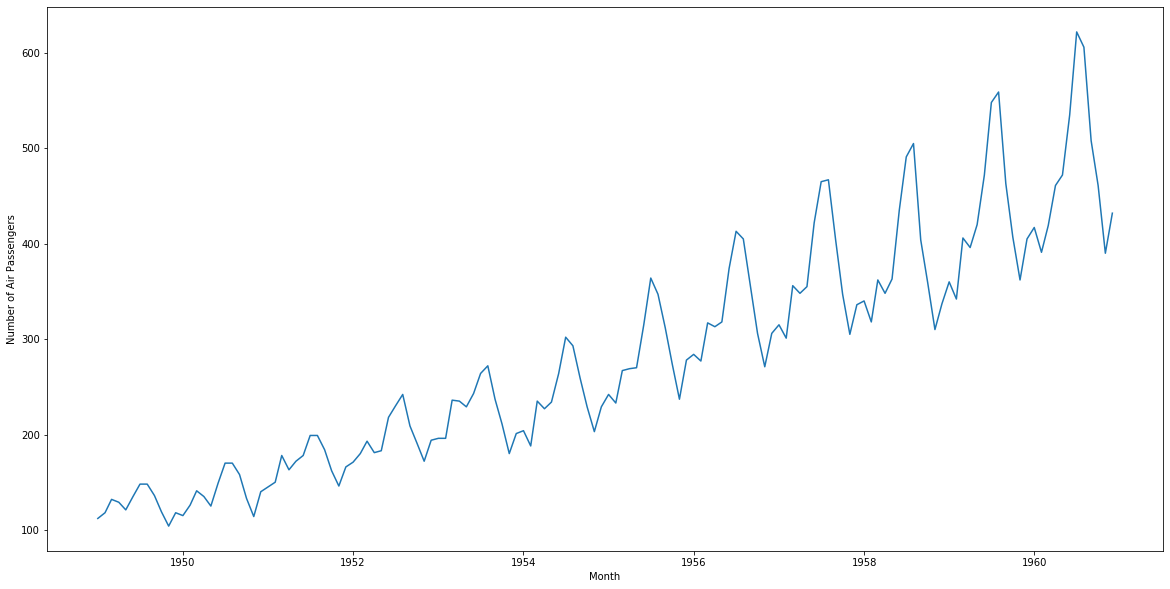

In [8]:
plt.figure(figsize=(20,10))
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")
plt.plot(data)

Рассчитываем скользящее среднее (среднее значение за последние n периодов, в данном случае n = 12 (месяцы)) и скользящее среднее квадратичное отклонение (аналогично).

In [9]:
rolmean = data.rolling(window=12).mean()
rolstd = data.rolling(window=12).std()
print(rolmean.head(15))
print(rolstd.head(15))

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333
            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01    13.720147
1950-01-01    13.453342
1950-02-01    13.166475
1950-03-01    13.686977


Теперь отразим на графике число пассажиров, скользящее среднее и скользящее среднее квадратичное отклонение  на одном графике. Обратите внимание, что скользящее среднее начинается не с первого года!

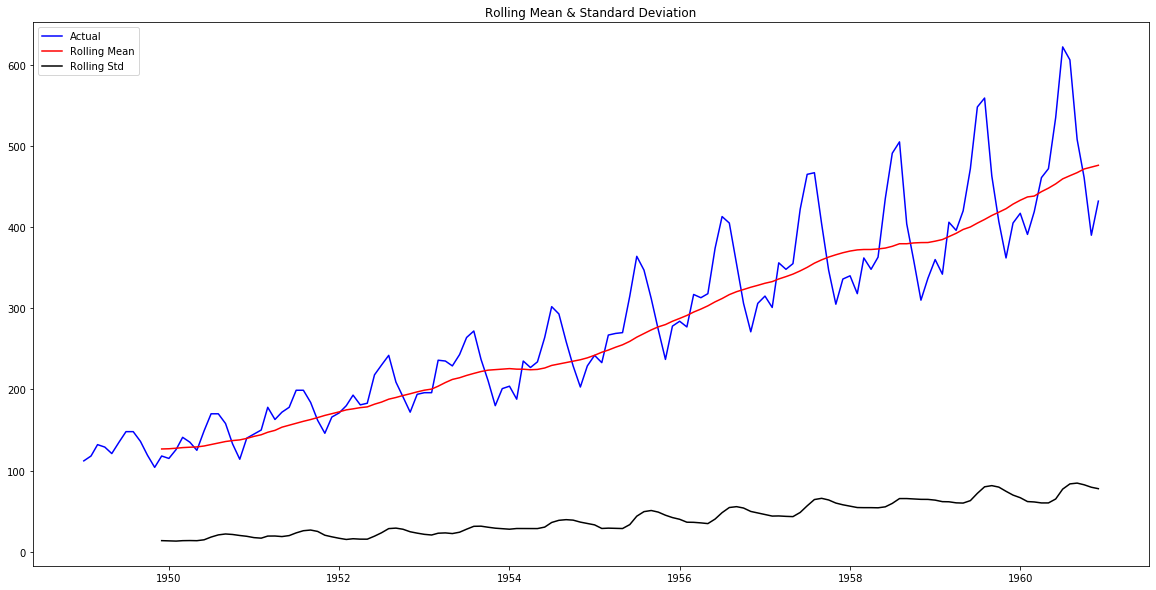

In [10]:
plt.figure(figsize=(20,10))
actual=plt.plot(data, color='blue', label='Actual')
mean_6=plt.plot(rolmean, color='red', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Визуализировав данные, можно заметить что ряд нестационарный. Для оценнки временных рядов необходима стационарность. Для того чтобы прийти к этому выводу необходимо провести тест Дики-Фуллера. Смотрим на критические значения, p-value! H0 для теста Дики-Фуллера - ряд нестационарный.

In [11]:
print('Dickey-Fuller Test: ')
dftest=adfuller(data['#Passengers'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


Для нормализации данных существует множество подходов, попробуем нормализацию при помощи взятия логарифма от данных, который сглаживает выбросы.

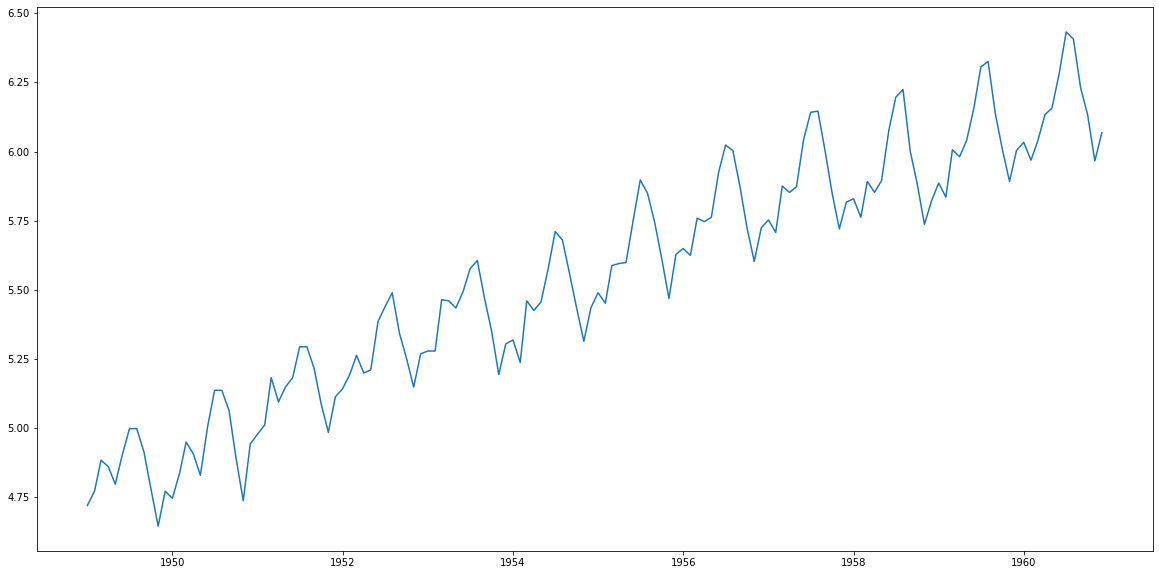

In [12]:
plt.figure(figsize=(20,10))
data_log = np.log(data)
plt.plot(data_log)

Отрисуем скользяее среднее для логарифма.

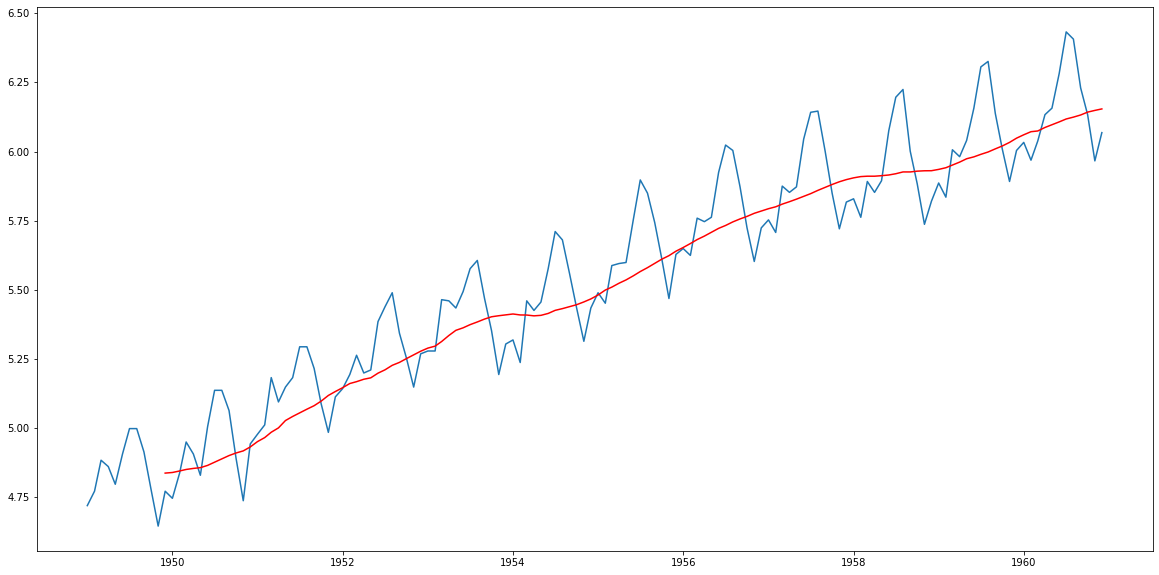

In [13]:
moving_avg = data_log.rolling(12).mean()
plt.figure(figsize=(20,10))
plt.plot(data_log)
plt.plot(moving_avg, color='red')

Как можно заметить, это не оказало ожидаемого значимого эффекта, ряд все равно нестационарный. Для того чтобы нормализировать данные, попробуем элиминировать тренд, исключая из каждого значение скользящее среднее для этого врменного момента. Опять возможно не для всех временных периодов!

In [14]:
data_log_diff = data_log - moving_avg
data_log_diff.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


Исключаем полученные значения NA, так как с ними работать не получится.

In [15]:
data_log_diff = data_log_diff.dropna()
data_log_diff.head(12)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


Аналогично рассчитываем скользящее среднее и среднее квадратичное отклонение.

In [16]:
rolmean_diff = data_log_diff.rolling(window=12).mean()
rolstd_diff = data_log_diff.rolling(window=12).std()
print(rolmean_diff.head(15))
print(rolstd_diff.head(15))

            #Passengers
Month                  
1949-12-01          NaN
1950-01-01          NaN
1950-02-01          NaN
1950-03-01          NaN
1950-04-01          NaN
1950-05-01          NaN
1950-06-01          NaN
1950-07-01          NaN
1950-08-01          NaN
1950-09-01          NaN
1950-10-01          NaN
1950-11-01     0.047517
1950-12-01     0.053876
1951-01-01     0.063879
1951-02-01     0.068340
            #Passengers
Month                  
1949-12-01          NaN
1950-01-01          NaN
1950-02-01          NaN
1950-03-01          NaN
1950-04-01          NaN
1950-05-01          NaN
1950-06-01          NaN
1950-07-01          NaN
1950-08-01          NaN
1950-09-01          NaN
1950-10-01          NaN
1950-11-01     0.137463
1950-12-01     0.133467
1951-01-01     0.125693
1951-02-01     0.123864


Отразим все полученные данные на одном графике, теперь наш временной ряд похож на стационарный!

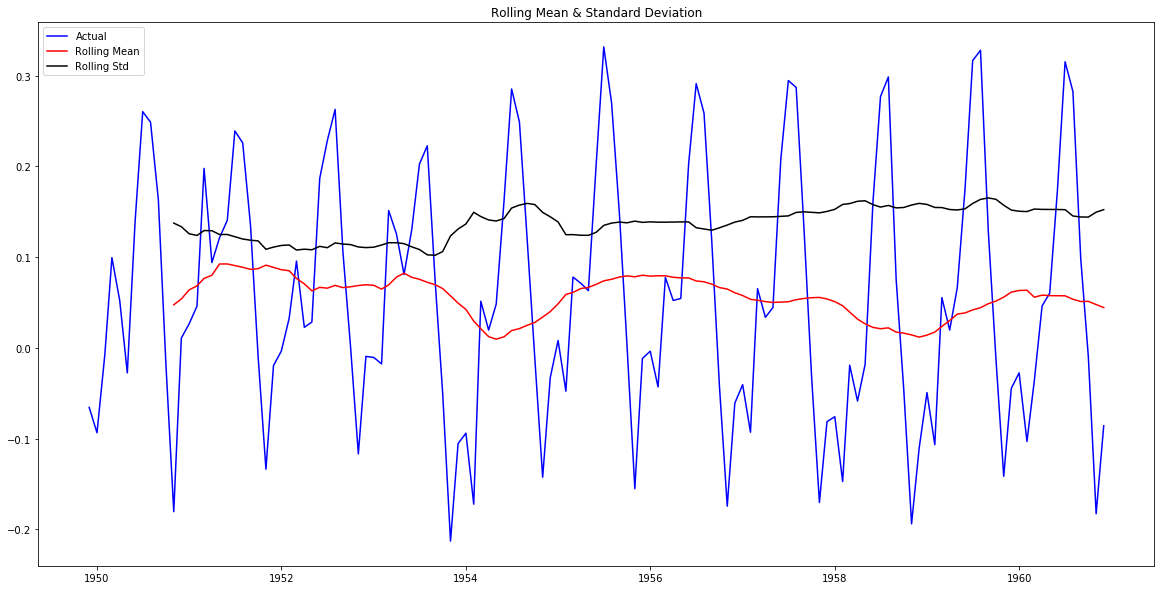

In [17]:
plt.figure(figsize=(20,10))
actual_diff = plt.plot(data_log_diff, color='blue', label='Actual')
mean_diff = plt.plot(rolmean_diff, color='red', label='Rolling Mean') 
std_diff = plt.plot(rolstd_diff, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Проведем тест Дики-Фуллера чтобы подтвердить наше предположение о стационарности ряда. Опять обращаем внимание на p-value и критические значения.

In [18]:
print('Dickey-Fuller Test: ')
dftest = adfuller(data_log_diff['#Passengers'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic           -3.162908
p-value                   0.022235
Lags Used                13.000000
No. of Obs              119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


Теперь попробуем проинтегрировать временной ряд до порядка 1. Это значит из каждого значения вычесть предыдущее. Заранее считаем скользящее среднее и среднее квадратичное отклонение.

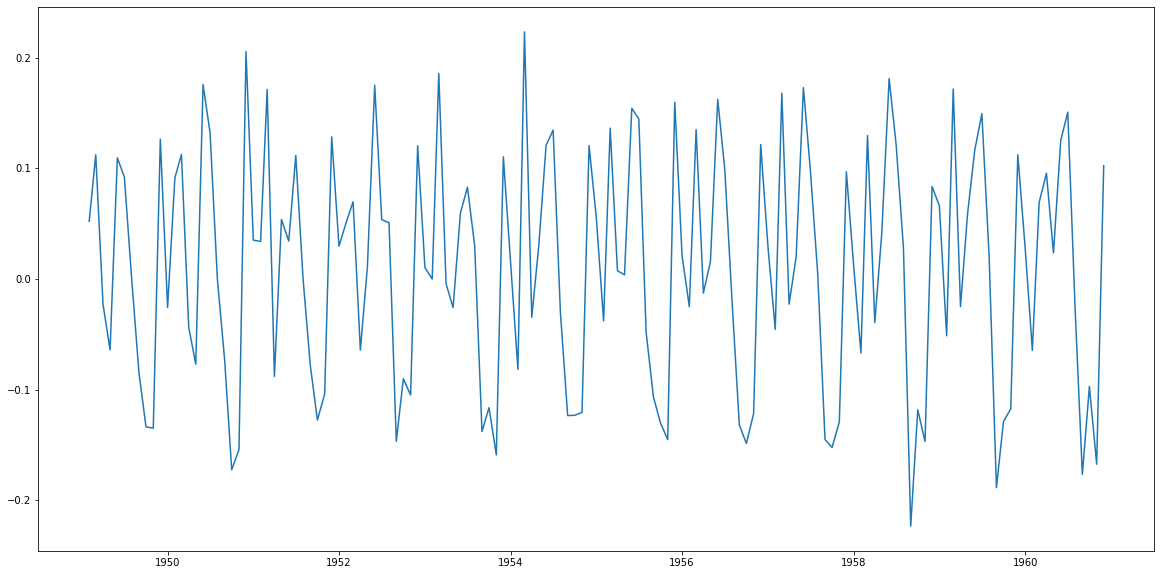

In [19]:
plt.figure(figsize=(20,10))
data_log_diff_2 = data_log - data_log.shift()
data_log_diff_2 = data_log_diff_2.dropna()
rolmean_diff_2 = data_log_diff_2.rolling(window=12).mean()
rolstd_diff_2 = data_log_diff_2.rolling(window=12).std()
plt.plot(data_log_diff_2)

Визуализируем данные аналогично предыдущим пунктам. Ряд выглядит стационарным, это хорошо!

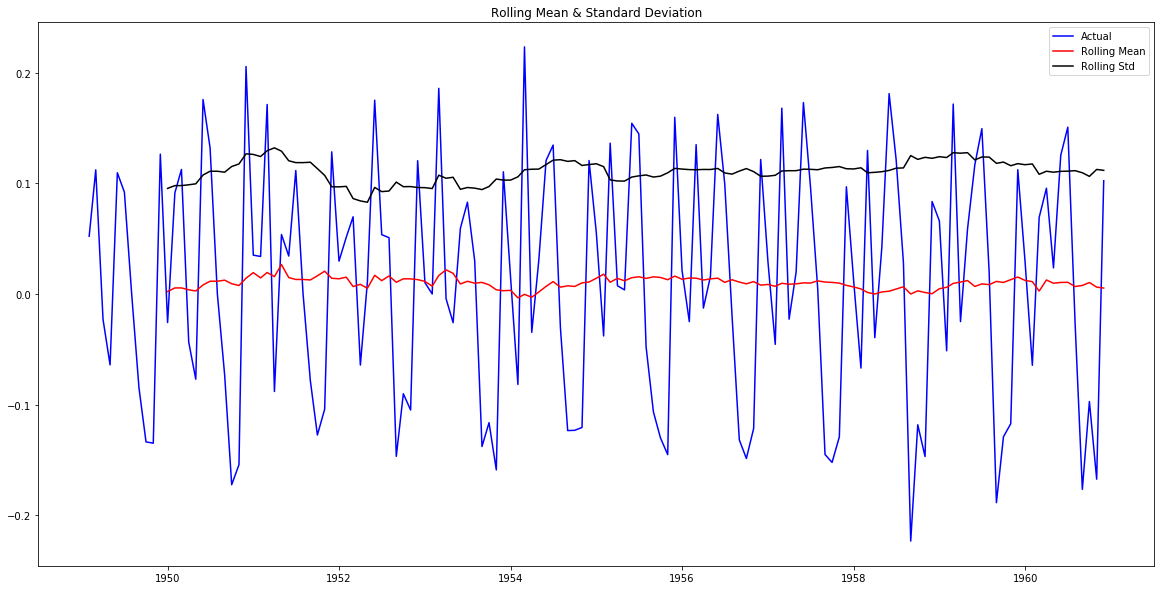

In [20]:
plt.figure(figsize=(20,10))
actual_diff = plt.plot(data_log_diff_2, color='blue', label='Actual')
mean_diff_2 = plt.plot(rolmean_diff_2, color='red', label='Rolling Mean') 
std_diff_2 = plt.plot(rolstd_diff_2, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Опять обратимся к тесту Дики-Фуллера, наше предположение о стационарности в целом подтверждается!

In [21]:
print('Dickey-Fuller Test: ')
dftest = adfuller(data_log_diff_2['#Passengers'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic           -2.717131
p-value                   0.071121
Lags Used                14.000000
No. of Obs              128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


Теперь выделим отдельно на наших графика сезонность, тренд и остатки.

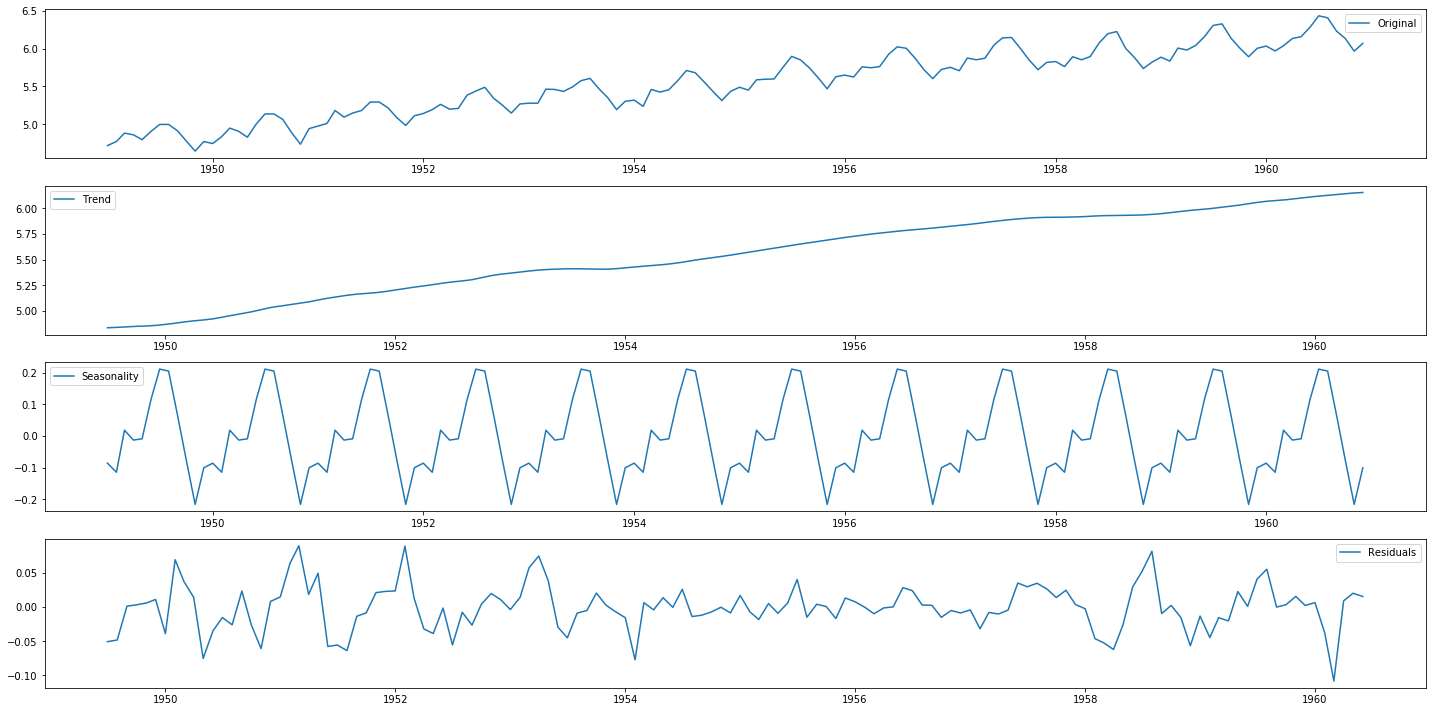

In [22]:
decomposition = seasonal_decompose(data_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Строим скользящие средние/средние квадратичные отклонения для остатков.

In [23]:
rolmean_res = residual.rolling(window=12).mean()
rolstd_res = residual.rolling(window=12).std()
print(rolmean_res.head(15))
print(rolstd_res.head(15))

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
1949-06-01   NaN
1949-07-01   NaN
1949-08-01   NaN
1949-09-01   NaN
1949-10-01   NaN
1949-11-01   NaN
1949-12-01   NaN
1950-01-01   NaN
1950-02-01   NaN
1950-03-01   NaN
Name: resid, dtype: float64
Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
1949-06-01   NaN
1949-07-01   NaN
1949-08-01   NaN
1949-09-01   NaN
1949-10-01   NaN
1949-11-01   NaN
1949-12-01   NaN
1950-01-01   NaN
1950-02-01   NaN
1950-03-01   NaN
Name: resid, dtype: float64


Проверим стационарность нащих остатков, сначала смоделируем графически.

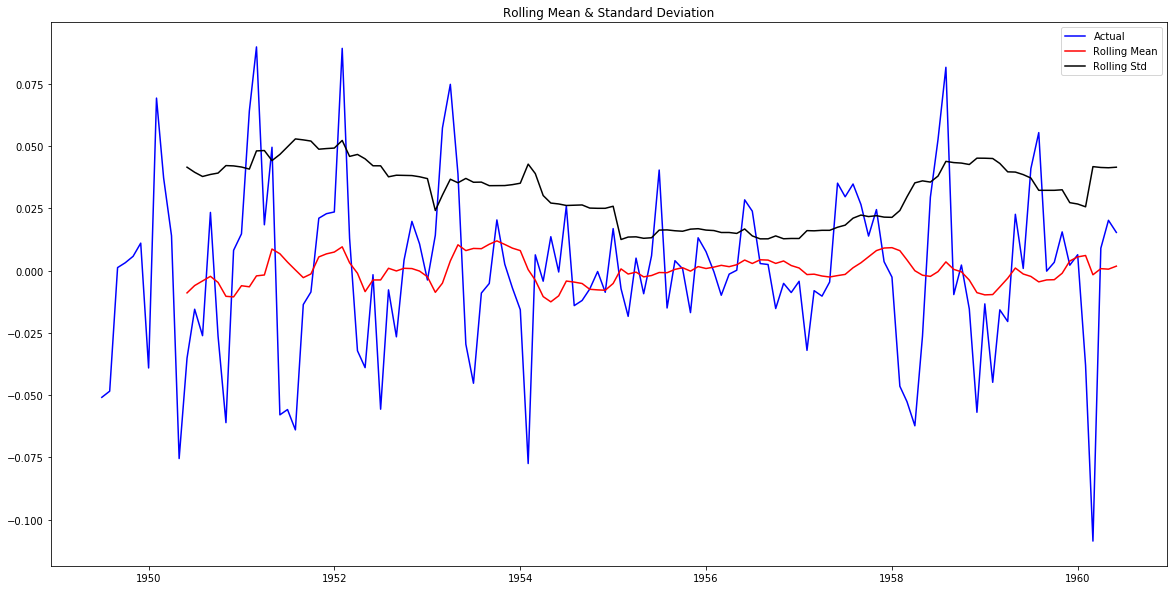

In [24]:
data_log_decompose = residual
data_log_decompose.dropna(inplace=True)
plt.figure(figsize=(20,10))
actual_res = plt.plot(data_log_decompose, color='blue', label='Actual')
mean_res = plt.plot(rolmean_res, color='red', label='Rolling Mean') 
std_res = plt.plot(rolstd_res, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Проводим тест Дики-Фуллера. Получаем что ряд стационарный, все хорошо.

In [25]:
print('Dickey-Fuller Test: ')
dftest = adfuller(data_log_decompose, autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic         -6.332387e+00
p-value                 2.885059e-08
Lags Used               9.000000e+00
No. of Obs              1.220000e+02
Critical Value (1%)    -3.485122e+00
Critical Value (5%)    -2.885538e+00
Critical Value (10%)   -2.579569e+00
dtype: float64


Прогнозирование временных рядов. Используем для этого модель ARIMA:  
AR - AutoRegressive - число лагов зависимой переменной  
I - Integrated - первая разность, в которой ряд становится стационарным  
MA - MovingAverage - число лагов для ошибок модели

In [26]:
lag_acf = acf(data_log_diff_2, nlags=20)
lag_pacf = pacf(data_log_diff_2, nlags=20, method='ols')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Для того чтобы оценить степень MA строим график ACF. Оценивает корреляцию временного ряда с лагированной версией себя. Выбираем ближайшее большее целое значение, которое впервые пересекает верхнюю границу доверительного интервала (в данном случае это 2)

Text(0.5, 1.0, 'Autocorrelation Function')

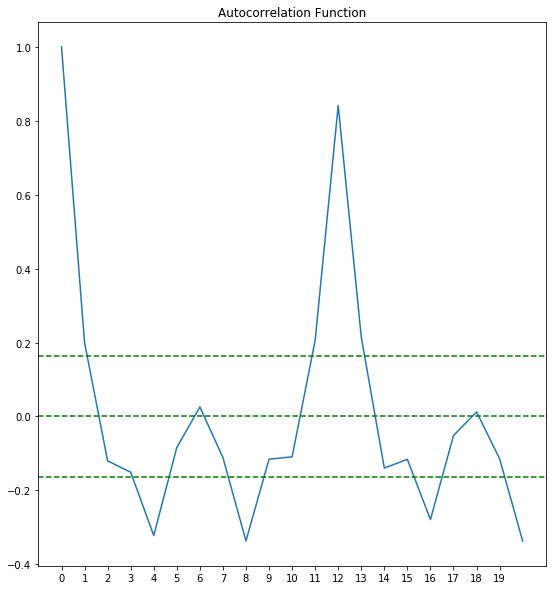

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff_2)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff_2)),linestyle='--',color='green')
plt.xticks(np.arange(0, 20, step=1))
plt.title('Autocorrelation Function')

Для того чтобы оценить степень AR строим график PACF. Оценивает корреляцию временного ряда с лагированной версией себя, исключая объясненную доли предыдущими лагами. Выбираем ближайшее большее целое значение, которое впервые пересекает верхнюю границу доверительного интервала (в данном случае это 2)

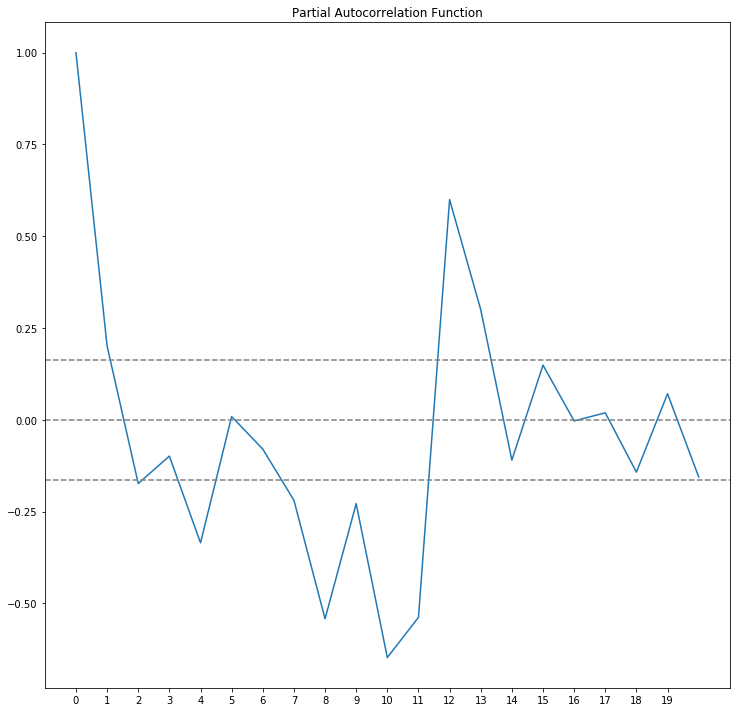

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff_2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff_2)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xticks(np.arange(0, 20, step=1))
plt.tight_layout()

Степень интегрирования I = 1, как мы уже выяснили раньше. Получаем, что нам необходимо использовать для прогнозирования модель ARIMA(2,1,2). Спрогнозируем модель ARIMA и графически отобразим.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


plotting ARIMA model


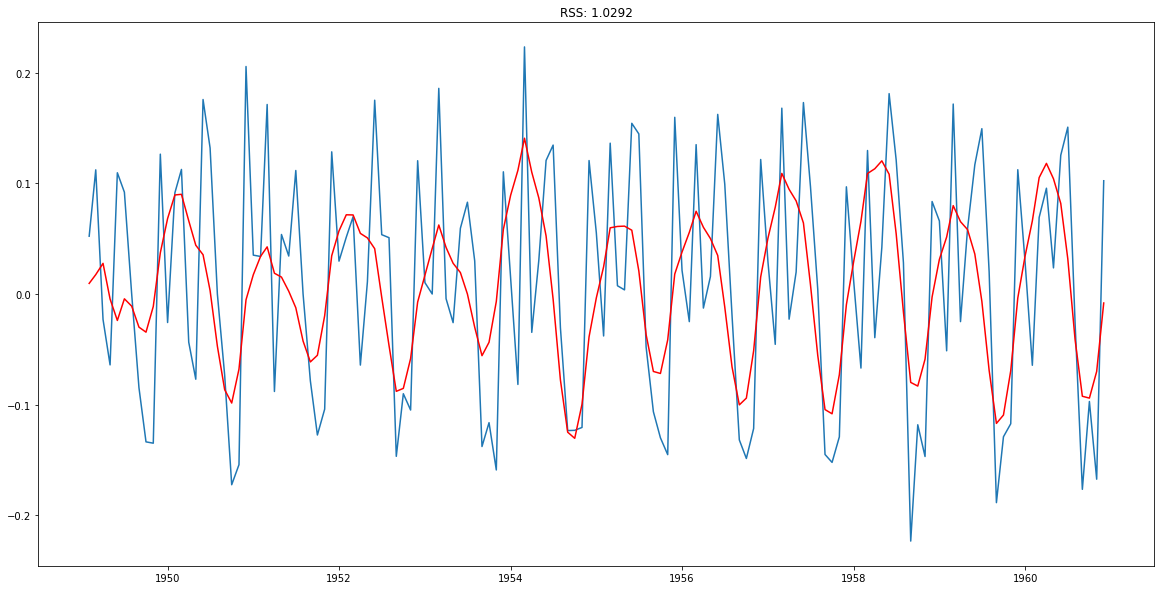

In [29]:
plt.figure(figsize=(20,10))
model=ARIMA(data_log, order=(2,1,2))
results=model.fit(disp=-1)
plt.plot(data_log_diff_2)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-data_log_diff_2['#Passengers'])**2))
print('plotting ARIMA model')

Теперь построим прогноз на будущие периоды на основе построенной модели ARIMA. Отобразим графически прогноз, синяя линяя - прогнозное значение, серая область - доверительный интервал.

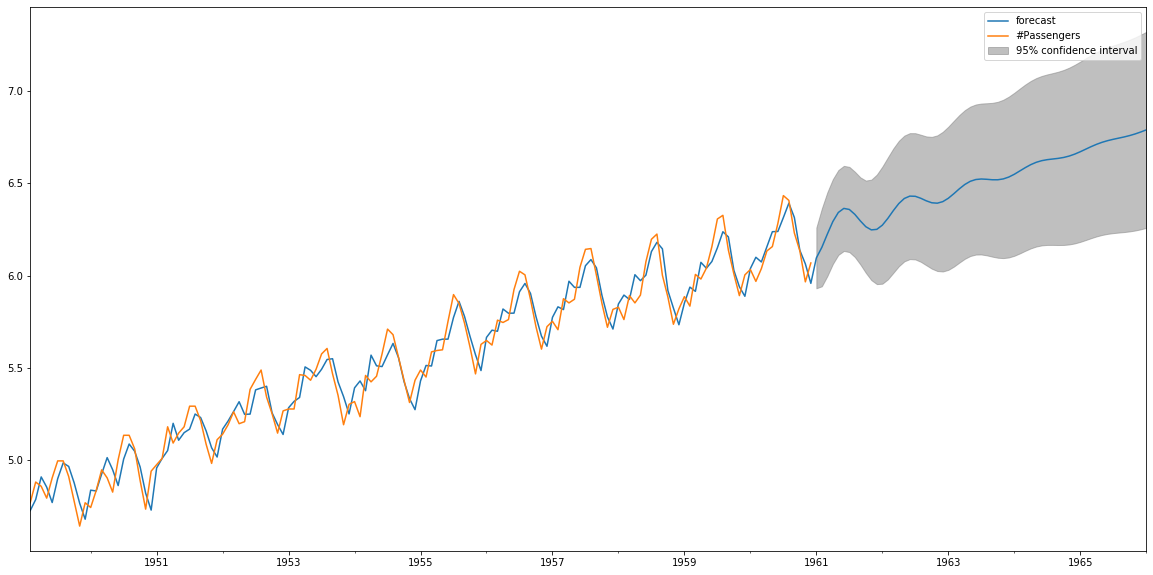

In [30]:
rcParams['figure.figsize']=20,10
results.plot_predict(1,204)
x = results.forecast(steps=240)

Посмотрим на предсказанные нами значения (синяя линия).

In [31]:
x = results.forecast(steps=5)
print(x[0])

[6.09553391 6.15281403 6.2244297  6.29241111 6.3416473 ]
